## Downstream Task: Pascal

Now that we've pretrained a network to fill in image patches, let's create a task that will allow us to benchmark how well our pretext task works. We can imagine a variety of downstream tasks including segmentation, objection detection and classification across a range of image distributions including natural photographs or medical images.

To keep things simple for now, we'll just try image classification on the Pascal VOC dataset.

In [1]:
import json
import torch

from collections import Set
import numpy as np
import pandas as pd

from fastai2.metrics import accuracy_multi, FBeta
from fastai2.basics import DataBlock, RandomSplitter

from fastai2.vision.all import ImageBlock, PILMask, get_image_files, PILImage, imagenet_stats
from fastai2.vision.core import get_annotations, Image, TensorBBox, TensorPoint, TensorImage
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform
from fastai2.vision.learner import cnn_learner, cnn_config, model_meta, _default_meta

from fastai2.vision.data import ImageDataBunch
from fastai2.data.block import MultiCategoryBlock
from fastai2.data.transforms import Normalize
from fastai2.data.external import download_url, URLs, untar_data

from torch.nn import BCEWithLogitsLoss
from torchvision.models import resnet34

/home/josh/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  after removing the cwd from sys.path.


In [2]:
pascal_path = untar_data(URLs.PASCAL_2012)
pascal_path

Path('/home/josh/.fastai/data/pascal_2012')

In [3]:
train_json = json.load(pascal_path/'train.json')

In [4]:
IMAGES,ANNOTATIONS,CATEGORIES = 'images', 'annotations', 'categories'
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

# Create a map from category ID to the category's string name
cats = {o[ID]:o['name'] for o in train_json[CATEGORIES]}
# Create a map from image ID to image file name
trn_fns = {o[ID]:o[FILE_NAME] for o in train_json[IMAGES]}

In [5]:
# We map each object to the set of classes contained in that object
image_to_category = {}
for annotation in train_json[ANNOTATIONS]:
    img_id = annotation['image_id']
    category_id = annotation['category_id']
    filename = trn_fns[img_id]
    
    if filename not in image_to_category:
        image_to_category[filename] = set()
        
    image_to_category[filename].add(cats[category_id])
    
# Now we join the set of classes present in an image into a single comma-delimited string
# We do this because it's easier to work with multilabel data in fastai this way
image_to_category = [(k, ','.join(v)) for k, v in image_to_category.items()]
image_to_category[:5]    

[('2008_000008.jpg', 'person,horse'),
 ('2008_000015.jpg', 'bottle'),
 ('2008_000019.jpg', 'dog'),
 ('2008_000023.jpg', 'tvmonitor,person,bottle'),
 ('2008_000028.jpg', 'car')]

In [6]:
train_df = pd.DataFrame(image_to_category)

In [7]:
data = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter())

In [8]:
# TODO: Resize images properly, right now they're cropped with way too much zoom
databunch = ImageDataBunch.from_df(train_df, 
                                   path=pascal_path/'train',
                                   fn_col=0,
                                   bs=8,
                                   item_tfms=[RandomResizedCrop(160)], #TODO: Not crop, just resize
                                   batch_tfms=[*aug_transforms(size=160, max_warp=0, max_rotate=0)],
                                   label_delim=','
                                  )                                  

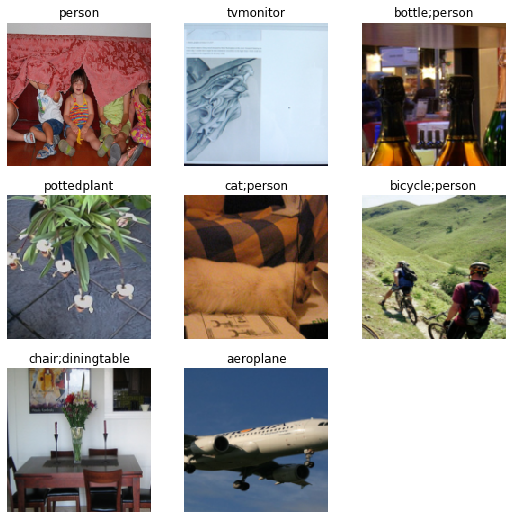

In [9]:
databunch.show_batch(max_n=9)

Now that we've got a "downstream" task, let's compare different approaches to get a sense for what works and what doesn't. To start we'll try:
- Using random weights
- Using weights from our pretext task
- Using ImageNet weights

## Run with random weights

In [10]:
loss = BCEWithLogitsLoss()
learn = cnn_learner(databunch, resnet34, pretrained=False, config=cnn_config(), loss_func=loss, metrics=[accuracy_multi])

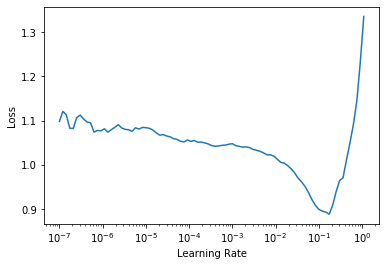

In [11]:
learn.lr_find()

In [12]:
# Fine tune on this task
learn.fit_one_cycle(5, lr_max=10e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.347857,0.480312,0.917192,00:22
1,0.264835,0.257706,0.921610,00:22
2,0.252228,0.248381,0.923228,00:21
3,0.241611,0.237088,0.923272,00:22
4,0.239468,0.234511,0.923228,00:22


## Run with pretext weights

In [13]:
loss = BCEWithLogitsLoss()
learn = cnn_learner(databunch, resnet34, pretrained=False, config=cnn_config(), loss_func=loss, metrics=[accuracy_multi])

In [14]:
# Load backbone from saved model
# NOTE: This step depends on running all cells from 02_ImagePatches_ImageWang.ipynb
state_dict = torch.load('pascal_15_epoch.pth')
learn.model[0].load_state_dict(state_dict)

<All keys matched successfully>

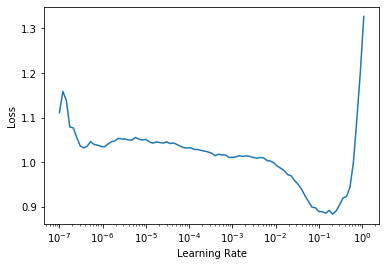

In [15]:
learn.lr_find()

In [16]:
# Fine tune on this task
learn.fit_one_cycle(5, lr_max=10e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.566700,5465.243164,0.845538,00:21
1,0.588867,477.118378,0.921654,00:21
2,0.371943,28067.634766,0.919948,00:21
3,0.278341,20202.271484,0.919073,00:21
4,0.254108,20029.531250,0.920035,00:21


## Run with ImageNet weights

In [17]:
loss = BCEWithLogitsLoss()
learn = cnn_learner(databunch, resnet34, pretrained=True, config=cnn_config(), loss_func=loss, metrics=[accuracy_multi])

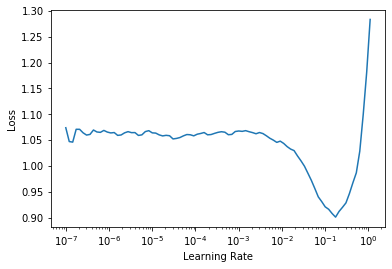

In [18]:
learn.lr_find()

In [19]:
# Fine tune on this task
learn.fit_one_cycle(5, lr_max=10e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.262754,0.227894,0.926378,00:19
1,0.213406,0.174862,0.934996,00:18
2,0.186914,0.148659,0.945407,00:18
3,0.172405,0.131809,0.950394,00:19
4,0.161715,0.126127,0.953543,00:18
